The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

Solution
---

**Note to Reviewer**

This notebook contains stage by stage implementation. README explaining the steps in detail as per rubric is contained in `writeup.html`

### Code below finds Chessboard corners and draws them


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib qt


### We first find distortion coefficient for camera using chessboard images and store these in a pickle file for later use

The apporach used is same as one explained in lectures.`objp` contains the chessboard corners in real world and here we assume the chessboard lies on plane `z= 0` so `pbjp` will have `(x,y,z)` as `(0,0,0), (1,0,0)...(8,0,0),(0,1,0)...(8,1,0)...(8,5,.0)` and this will be repated for each chessboard corner image making `objpoints` to be a repeated array containing multiple copies of `objp` - one for each image.

`imgpoints` will contain the chessboard corners in the camera plane. 

These two will be used in `cv2.calibrateCamera` to find the distortion coefficients and store them in a pickle file for later use.


In [2]:
nx = 9 #no of points per row
ny = 6 #no of points per column

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')



In [3]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### using object and image points above, find and store distortion coefficients

In [4]:

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

#### Using the distortion coefficients found above, undistort the test images and store them in folder `output_images\`
One sample image is also shown below

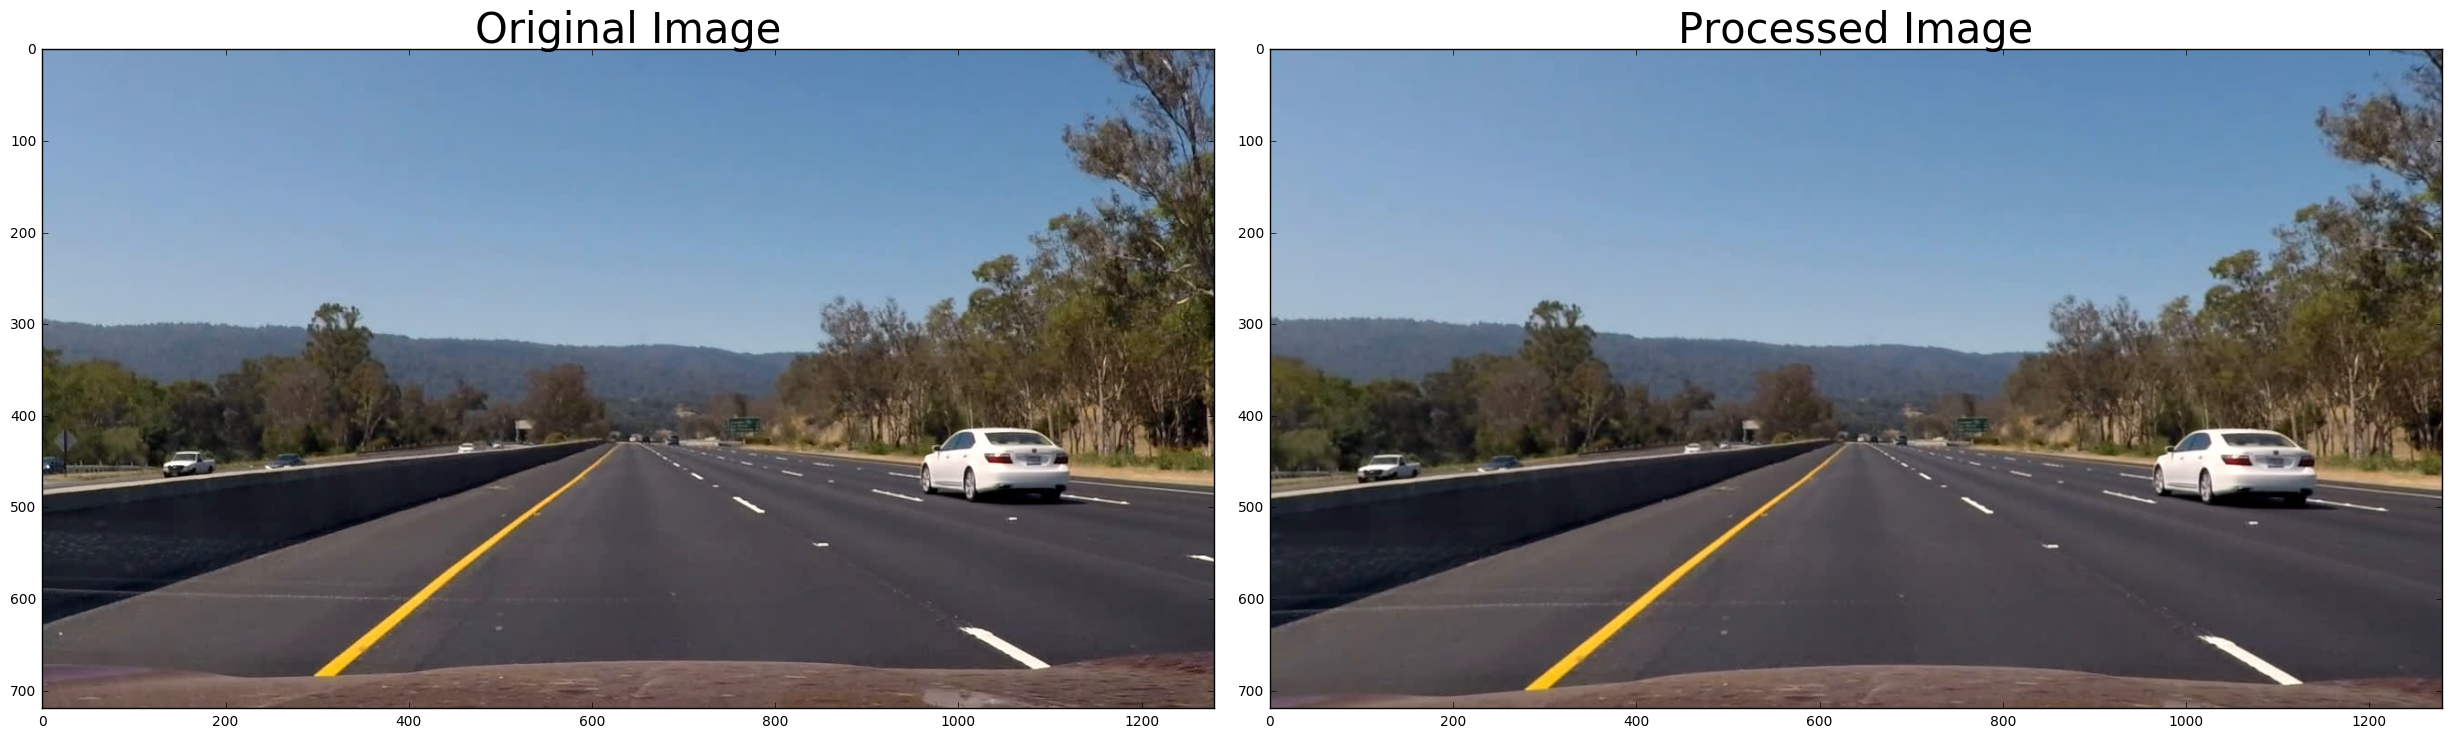

In [5]:
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# visualize two images - left original and right processed image
def visualize(src, dst, bgr_type = False, dst_is_gray=False):
    if bgr_type:
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(src)
    ax1.set_title('Original Image', fontsize=30)
    if dst_is_gray:
        ax2.imshow(dst, cmap='gray')
    else:
        ax2.imshow(dst)
    ax2.set_title('Processed Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img, mtx, dist)
    cv2.imwrite('output_images/undist_'+fname[12:],dst)
    #just plot test1.jpg image
    if fname[12:] == 'test7.jpg':
        visualize(img, dst, bgr_type=True)


### With distortion coefficients calculated, now move to applying thresholding

I experimented with many combinations o threshold and finally settled with only SobelX with magnitude threshold of `(20,100)` along with S-channel threshold of `(170,220)`

The processed images with pipeline = undistort->threshold is stored in output folder. One of the sample is also displayed in the plot below

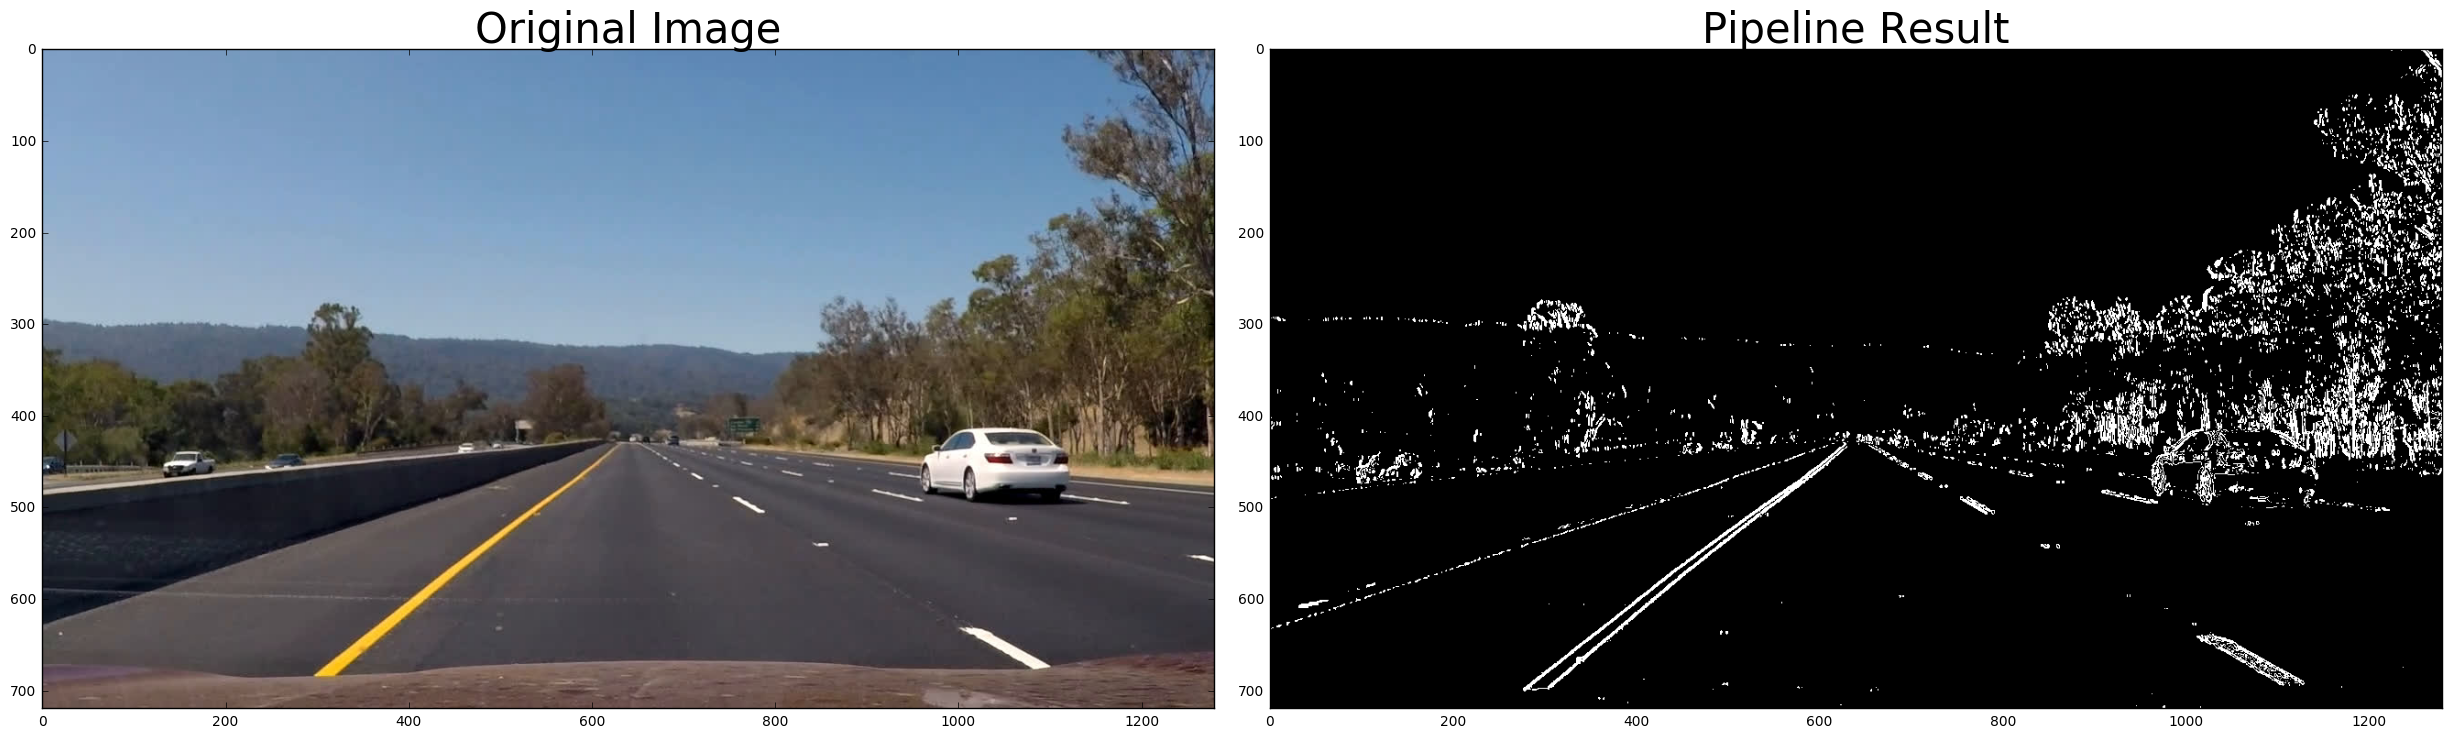

In [6]:

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# this pipeline takes the original image and
# applies a combined gradient and S channel thresholding
# imgae is supposed be read with imread giving RGB colors
def threshold(img, sobel_kernel=3, s_thresh=(170, 220), mag_thresh=(20, 100)):
    img = np.copy(img)
    
    #Do Sobel_mag
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # removed sobely after trial and error
    gradmag = np.sqrt(sobelx**2 + sobely**2*0)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    #Do S channel Thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    #Combine two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1)] = 1

    return combined_binary


# test this part of pipeline i.e. undistort and Threshold

img = mpimg.imread('test_images/test7.jpg')
undist = undistort(img, mtx, dist)
result = threshold(undist)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

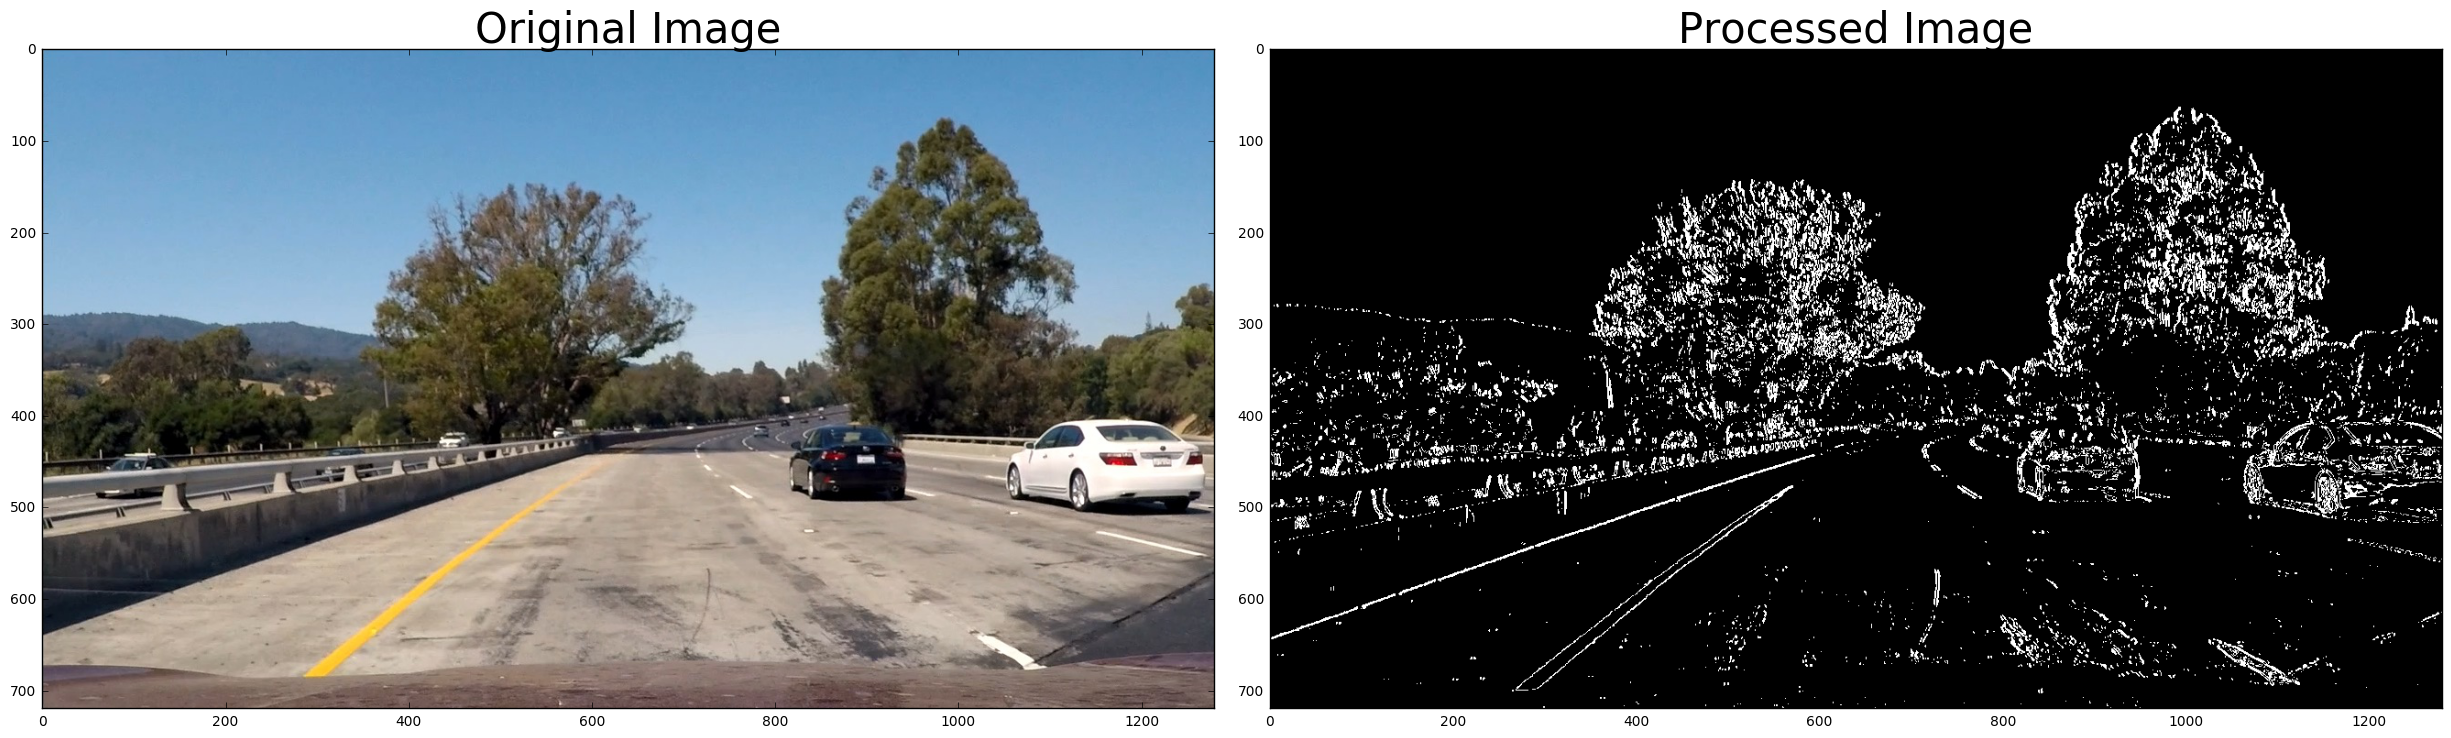

In [7]:
# process all test images and store output
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    result = threshold(undist)
    mpimg.imsave('output_images/undist_thresh_'+fname[12:],result, cmap='gray')
    if fname[12:] == 'test1.jpg':
        visualize(img, result, bgr_type = False, dst_is_gray=True)


### Now we do perspective transform

This step involed taking a test image which had straight lines. Indentifying 4 points on undistored image which lie on the lane and then transofrming them to a perspective where the bounded region appears as a rectnagle to provide a top down view. 

The undistored image with 4 points and the perspective of undistored image with 4 points is shown below to check the sanity. Also shown is the perspective transform of the thresholded image.

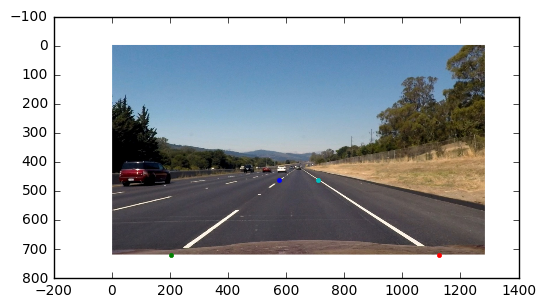

In [8]:
%matplotlib inline
img = mpimg.imread('output_images/undist_straight_lines2.jpg')
#print (img.shape)
plt.imshow(img)

#plt.plot(625,450,'.') # top left
#plt.plot(243, 719, '.') # bottom left
#plt.plot(1160, 719, '.') # bottom right
#plt.plot(725, 450, '.') # top right

plt.plot(576,460,'.') # top left
plt.plot(203, 719, '.') # bottom left
plt.plot(1127, 719, '.') # bottom right
plt.plot(710, 460, '.') # top right

# Trapiziod for image undist_straight_lines2.jpg is given above. THis is used to create the perspective tarnsform

# 4 points on the lane lines that will appear straight in topdown view
src = np.float32(
    [[576, 460],
     [203, 719],
     [1127,719],
     [710, 460]
    ])
#Cooridate of above 4 points that should appear in topdown view
dst = np.float32(
    [[320,0],
     [320, 719],
     [960,719],
     [960,0]
    ])

# calculate perspective transform
M = cv2.getPerspectiveTransform(src, dst)

#calculate inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

M_pickle = {}
M_pickle["M"] = M
M_pickle["Minv"] = Minv
pickle.dump( M_pickle, open( "M_pickle.p", "wb" ) )


### See the result of Perspective transform on the image used for creating the transform Matrix

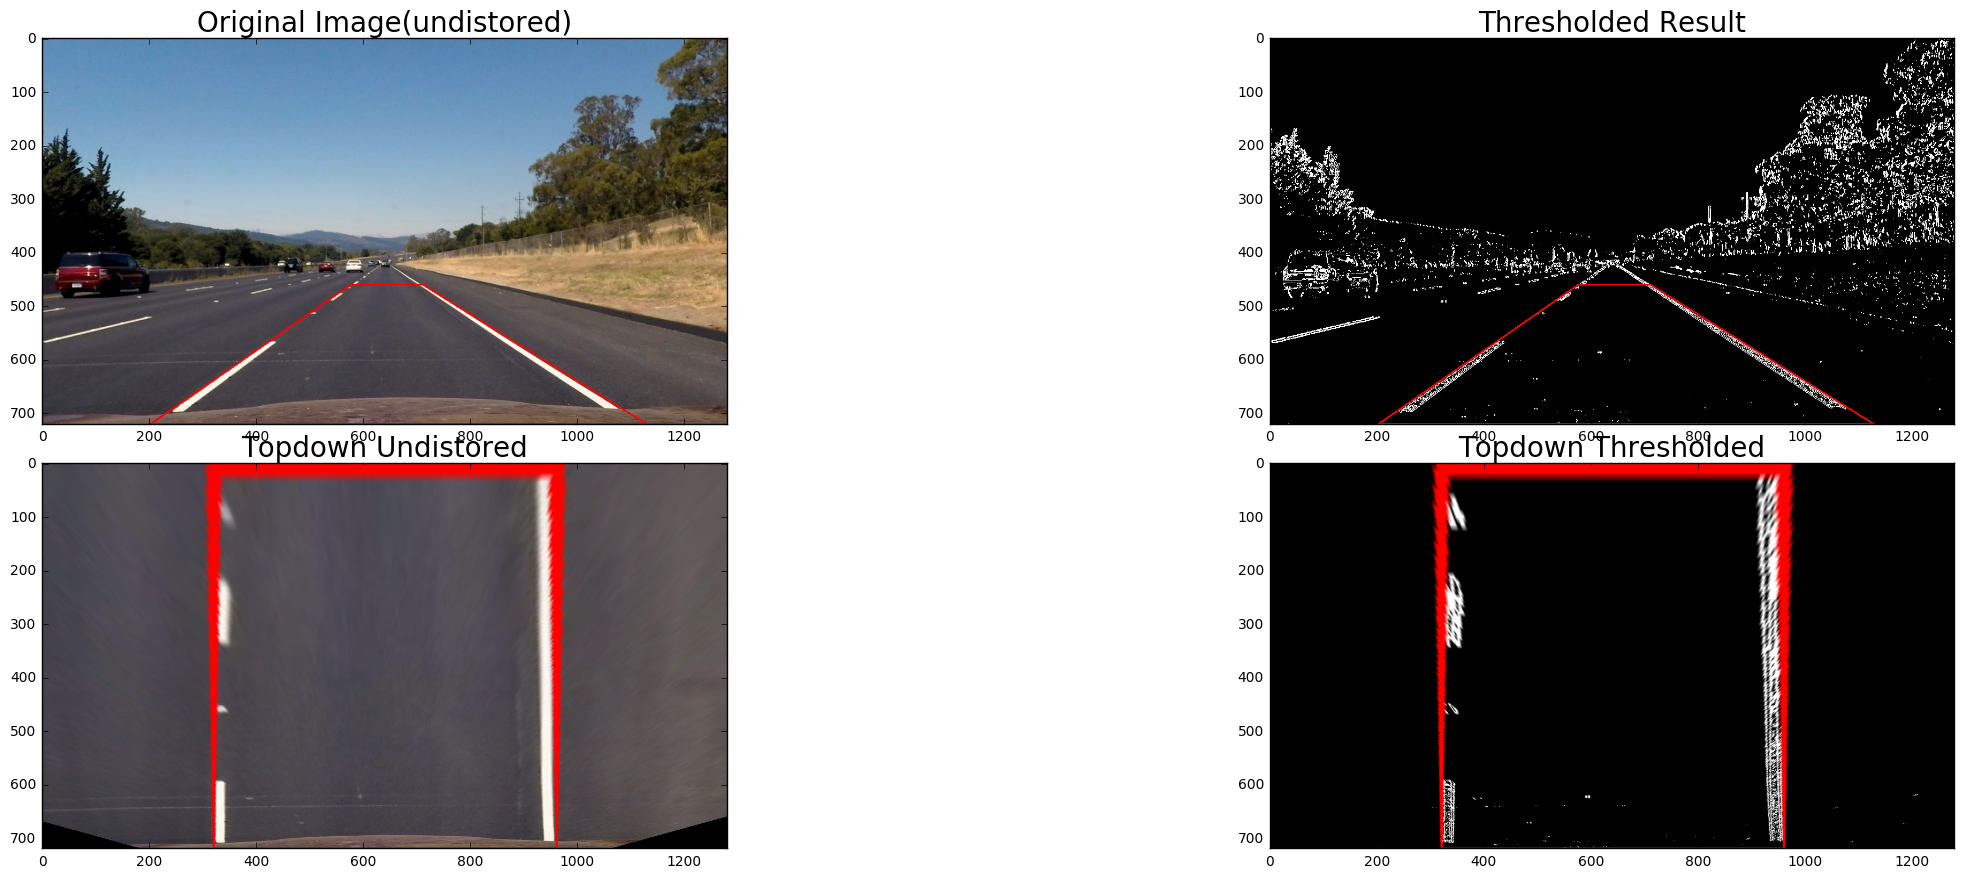

In [9]:
# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# readd in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]

img = mpimg.imread('test_images/straight_lines2.jpg')



undist = undistort(img, mtx, dist)

thresh = threshold(undist)
# convert gray sclae to RGB
thresh_3 = np.dstack((thresh, thresh, thresh))*255
#put bounding box lines on Thresholded image
cv2.line(thresh_3,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=2 )
img_size = (thresh.shape[1], thresh.shape[0])

# create a copy of undistored image with bunding box
undist_boxed = np.copy(undist)
cv2.line(undist_boxed,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2 )
cv2.line(undist_boxed,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2 )
cv2.line(undist_boxed,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2 )
cv2.line(undist_boxed,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=2 )

warped = cv2.warpPerspective(thresh_3, M, img_size)
warped_org = cv2.warpPerspective(undist_boxed, M, img_size)

cv2.line(undist,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=2 )


#draw line of undistort


# Plot the result
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image(undistored)', fontsize=20)
ax2.imshow(thresh_3)
ax2.set_title('Thresholded Result', fontsize=20)
ax3.imshow(warped_org)
ax3.set_title('Topdown Undistored', fontsize=20)
ax4.imshow(warped)
ax4.set_title('Topdown Thresholded', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Process all images store the result of pipeline undistort->threshold->Perspective
All the original images are taken and procssed using pipeline: undistort -> threshold -> perspective Xform. The results are stored in the directory 'output+images/'

In [10]:
# process all test images and store outputafter warping
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    thresh = threshold(undist)
    thresh_3 = np.dstack((thresh, thresh, thresh))*255
    cv2.line(thresh_3,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=1 )
    img_size = (thresh.shape[1], thresh.shape[0])
    warped = cv2.warpPerspective(thresh_3, M, img_size)
    mpimg.imsave('output_images/warped_'+fname[12:],warped)


### Now move on to Locating lines

In this stage, we use the concept of sliding window as explained in the lectures. We first find intial lane centers by doing a histogram of perspecctive image (only the bottom half). We then find the peaks in histogram on the left half and right half. We use these as starting points and then use a sliding window of size 100(i.e. sieze of 50 on each side of center) and a window height of 60. For all the detected pixels in this window, average of x corodinates of all pixels are found and used as x-center of sliding window for next iteration. The idea is the remove all the non lane pixels from the image.  

C:\Users\soais\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


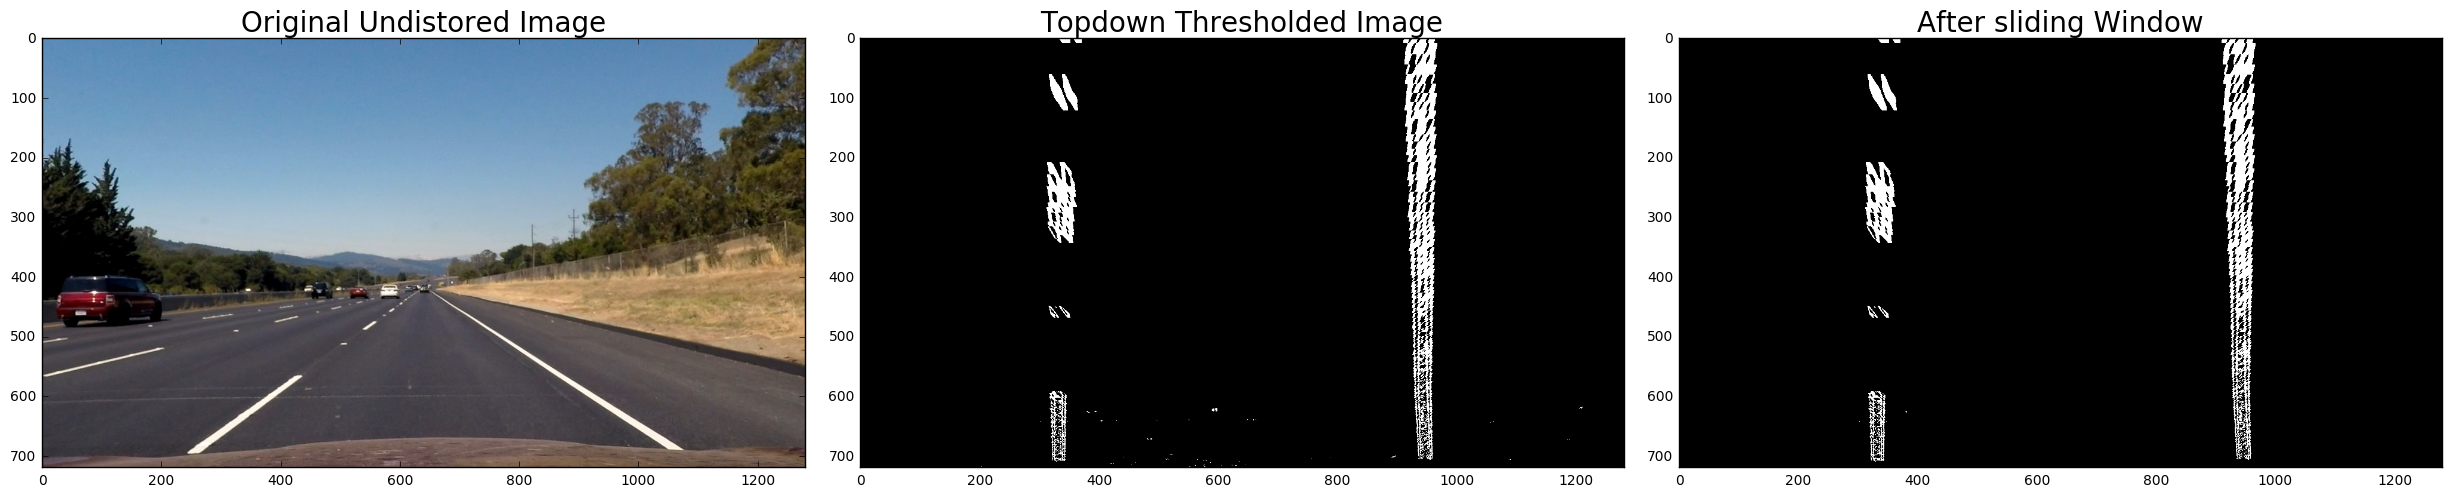

In [11]:
def initial_lane_centers(h):
    midp = np.int(h.shape[0]/2)
    lc = np.argmax(h[:midp])
    rc = np.argmax(h[midp:])+midp
    return (lc, rc)


def sliding_windows(src, dst, mid, win_size=50, win_height=60):
    for row in range(src.shape[0],0,-win_height):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[max(0,row-win_height):row, st:end] = src[max(0,row-win_height):row, st:end]
        ones = np.where(src[max(0,row-win_height):row, st:end] == 1)
        # ones will be a tuple where first element i.e. ones[0] is the y indices of non zero elments and 2nd element i.e. ones[1] is
        # x indicies of non zero values. We will extract only the 2nd element and take an average to findd the 
        # x center of slice
        if len(ones[1]):
            mid = np.int(np.mean(ones[1])+st)
            


img = mpimg.imread('test_images/straight_lines2.jpg')
undist = undistort(img, mtx, dist)
thresh = threshold(undist)
img_size = (thresh.shape[1], thresh.shape[0])
warped = cv2.warpPerspective(thresh, M, img_size)
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
lc, rc = initial_lane_centers(histogram)
lines = np.zeros_like(warped)
sliding_windows(warped, lines, lc)
sliding_windows(warped, lines, rc)



# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Undistored Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Topdown Thresholded Image', fontsize=20)
ax3.imshow(lines, cmap='gray')
ax3.set_title('After sliding Window', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Process all images store the result of pipeline undistort->threshold->Perspective->isolate Lines

We now run the complete pipeline: `undistort->threshold->Perspective Xform ->isolate lines` on all the test images. Processed images form this pipeline are again stored in the output folder.

In [12]:
# process all test images and store outputafter warping and lane identification
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and process each image
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    thresh = threshold(undist)
    img_size = (thresh.shape[1], thresh.shape[0])
    warped = cv2.warpPerspective(thresh, M, img_size)
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    lc, rc = initial_lane_centers(histogram)
    lines = np.zeros_like(warped)
    sliding_windows(warped, lines, lc)
    sliding_windows(warped, lines, rc)    
    mpimg.imsave('output_images/only_lanes_'+fname[12:],lines, cmap='gray')

C:\Users\soais\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Next step is to fit the Right and Left Lines

After the lanes have been isolated in the Perspecive image. A second degree polynomial is fitted to estimate the lane boundary and use this fitted lane edges to color the lane in subsequent pipelines. 

In [13]:
def fit_poly(lane_img, plot_fit=False):
    # mid point on x axis to divide the image into two halfs
    midx = np.int(lane_img.shape[1]/2)
    yvals = np.linspace(0,img.shape[0]-1,img.shape[1])
    left_ln_pts = np.where(lane_img[:,:midx]==1) #returns the tuple with first element all the y and 2nd all the x
    right_ln_pts = np.where(lane_img[:,midx:]==1)
    left_fit = np.polyfit(left_ln_pts[0], left_ln_pts[1], 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_ln_pts[0], right_ln_pts[1]+midx, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    #now visualize the fit
    if plot_fit:
        plt.plot(left_ln_pts[1], left_ln_pts[0], 'o', color='red')
        plt.plot(right_ln_pts[1]+midx, right_ln_pts[0], 'o', color='red')
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, yvals, color='green', linewidth=3)
        plt.plot(right_fitx, yvals, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    #calculate Curvature in pixels
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meteres per pixel in x dimension
    y_eval = np.max(yvals)
    left_fit_cr = np.polyfit(left_ln_pts[0]*ym_per_pix, left_ln_pts[1]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_ln_pts[0]*ym_per_pix, (right_ln_pts[1]+midx)*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return (left_fit, left_curverad, right_fit, right_curverad)

7927.64857965 m 9325.41816257 m


(array([  2.69019912e-05,  -9.97631878e-02,   4.13066120e+02]),
 7927.6485796505031,
 array([  2.28829393e-05,   6.26764709e-02,   9.28899152e+02]),
 9325.4181625736874)

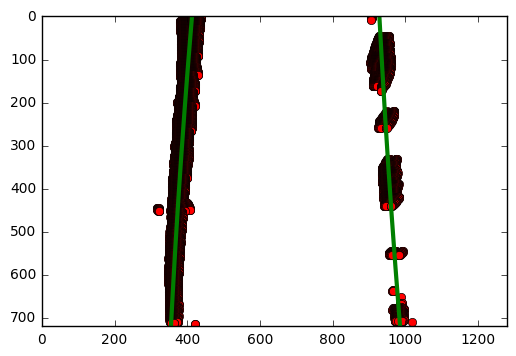

In [14]:
fit_poly(lines, True)

### Final Pipeline: Undistort -> threshold -> perspective -> Isolate lines -> fit lane lines -> Reverse Perspective with Lane and other data superimposed

Now the pipeline is ready. We do following additions
a) We used the fitted lane lines to find the radius of curvature of left and right lines. Also the offset of vehicle from center of the lane. This data is superimposed on the image. 
b) We also color the region between the lane line in green in the perspective image and then tarnsform it back from top down to regualr review using `Minv` - i.e. inverse transform. The result then is the un distored image with identified lane segment colored in green as well as suerimposed data of radius of curvature and lane position.

THe above pipeline suffices for single images. However, for processing video file, we use an object `Line` - one for right and left lane each. As we fit 2-degree curve, we store various parmaters such as estimated lane points - last n detections as well as average, estimated coefficients - last and average over last n and such some more data.

FOr each frame, if the fit was good in previous frame, we use the starting point of lanes from previous frame to start the sliding window. In case the fit in previous several frames was not good, we then assume that we have lost tracking of the lane and us histogram technique to once agin find the start of lane. 

We also use smoothening of coefficients to avoid jumps in the lane during video processing.

The pipeline below combines two more fucntionality - a) flag to control plotting of each step in pipeline `plot_result` flag, and b) to skip tracking for individual images vs use of tracking for video processing `video_clip` flag. 

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #no of history data
        self.n = 5
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients from last n iterations
        self.last_n_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None



def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# this pipeline takes the original image and
# applies a combined gradient and S channel thresholding
# imgae is supposed be read with imread giving RGB colors
def threshold(img, sobel_kernel=3, s_thresh=(170, 220), mag_thresh=(20, 100)):
    img = np.copy(img)
    
    #Do Sobel_mag
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # removed sobely after trial and error
    gradmag = np.sqrt(sobelx**2 + sobely**2*0)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    #Do S channel Thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    #Combine two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1)] = 1

    return combined_binary

def apply_perspective(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped


def initial_lane_centers(h):
    midp = np.int(h.shape[0]/2)
    lc = np.argmax(h[:midp])
    rc = np.argmax(h[midp:])+midp
    return (lc, rc)

# original sliding window which uses single row as window height
def sliding_windows_one_row(src, dst, mid, win_size=25):
    for row in range(src.shape[0]-1,-1,-1):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[row,st:end] = src[row,st:end]
        ones = np.where(src[row,st:end] == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+st)

def sliding_windows(src, dst, mid, win_size=50, win_height=60):
    for row in range(src.shape[0],0,-win_height):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[max(0,row-win_height):row, st:end] = src[max(0,row-win_height):row, st:end]
        ones = np.where(src[max(0,row-win_height):row, st:end] == 1)
        # ones will be a tuple where first element i.e. ones[0] is the y indices of non zero elments and 2nd element i.e. ones[1] is
        # x indicies of non zero values. We will extract only the 2nd element and take an average to findd the 
        # x center of slice
        if len(ones[1]):
            mid = np.int(np.mean(ones[1])+st)
            
            
def isolate_lanes(img, left_line, right_line, reinitiate=True):
    warped = np.copy(img)
    if reinitiate:
        histogram = np.sum(warped[warped.shape[0]/3:,:], axis=0)
        lc, rc = initial_lane_centers(histogram)
    else:
        yval = warped.shape[0]-1
        lc = left_line.best_fit[0]*yval**2+left_line.best_fit[1]*yval+left_line.best_fit[2]
        rc = right_line.best_fit[0]*yval**2+right_line.best_fit[1]*yval+right_line.best_fit[2]
        
    lines = np.zeros_like(warped)
    sliding_windows(warped, lines, lc)
    sliding_windows(warped, lines, rc)
    return lines

def detect_line(points, is_left_ln):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    # mid point on x-axis
    midx = np.int(points.shape[1]/2)
    # values from 0 to 719 - the nmber of pixels of the height of image
    yvals = np.linspace(0, points.shape[0]-1,points.shape[0])
    ln_pts = np.where(points==1) #returns the tuple with first element all the y and 2nd all the x
    # fit a degree 2 polynomial
    # usually atleast few points must be returned, however, in extreme case it does not happen, we return junk values
    if len(ln_pts[1])>0:
        fit = np.polyfit(ln_pts[0], ln_pts[1], 2)
        fitx = fit[0]*yvals**2 + fit[1]*yvals + fit[2]

        #find error in estimation and coffcient of determination
        x_est = fit[0]*ln_pts[0]**2 + fit[1]*ln_pts[0] + fit[2]
        fit_coeff = 1 - np.sum((x_est - ln_pts[1])**2) / np.sum((ln_pts[1] - np.mean(ln_pts[1]))**2)

        # curvature in meters
        fit_cr = np.polyfit(ln_pts[0]*ym_per_pix, ln_pts[1]*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])

        # offset of vehicle from center of lane
        if is_left_ln:
            _base_pos = 350 - abs(fitx[-1] - midx)  #350 is half of lane width in pixels
        else:
            _base_pos = abs(fitx[-1] - midx) - 350 
        #convert pixels to meters    
        _base_pos = _base_pos * xm_per_pix

        return (fit_coeff, fitx, fit, curverad, _base_pos, ln_pts[1], ln_pts[0])
    else:
        #return junk values if the input set of pixels is an empty array
        return (0,yvals, [0,0,0], 0, 0, np.array([0]), np.array([0]))
    

def fit_poly(lane_img, left_line, right_line, video_clip=False):
    if left_line == None or right_line == None:
        print("Lines can't be null. Check code")
        
    global bad_frames_cnt


    # mid point on x axis to divide the image into two halfs
    midx = np.int(lane_img.shape[1]/2)
    
    #retain only left half pixels in image
    left_lane_img = np.copy(lane_img)
    left_lane_img[:,midx:] = 0

    #retain only right half pixels in image
    right_lane_img = np.copy(lane_img)
    right_lane_img[:, :midx] = 0
    
    #process each image to collect the data
    l_fit_coeff, l_fitx, l_fit, l_curverad, l_base_pos, l_x, l_y = detect_line(left_lane_img, is_left_ln=True)
    r_fit_coeff, r_fitx, r_fit, r_curverad, r_base_pos, r_x, r_y = detect_line(right_lane_img, is_left_ln=False)
    #print(l_fit_coeff, r_fit_coeff)
        
    #now we should do sanity check of two detections and then decide to store the lines
    # check closeness of curvature - valid only if two line detections have high r2
    similar_curvature = abs(l_curverad - r_curverad) / (abs(l_curverad + r_curverad)/2) < 0.30

    # check if fitted lines are kind of parallel 
    # i.e. the separation at top and bottom are within 20%
    top_separation = r_fitx[0] - l_fitx[0]
    bottom_seaparation = r_fitx[-1] - l_fitx[-1]
    is_parallel =  abs(top_separation - bottom_seaparation) / (abs(top_separation + bottom_seaparation)/2) < 0.30
    
    #if both lines have high r2 and have similar curvature and kind of parallel
    if video_clip and similar_curvature and is_parallel:
        #lane found is good
        left_line.detected = True
        if len(left_line.recent_xfitted) != 0:
            left_line.recent_xfitted = np.vstack((l_fitx, left_line.recent_xfitted))[0:left_line.n+1]
        else:
            left_line.recent_xfitted = np.reshape(l_fitx,(1,-1))
        left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
        prev_l_fit = left_line.current_fit
        left_line.current_fit = l_fit
        if prev_l_fit != None:
            left_line.diffs = l_fit - prev_l_fit
        if len(left_line.last_n_fit) != 0: 
            left_line.last_n_fit = np.vstack((left_line.current_fit, left_line.last_n_fit))[0:left_line.n+1]
        else:
            left_line.last_n_fit = np.reshape(l_fit, (1,-1))
        left_line.best_fit = np.mean(left_line.last_n_fit, axis=0)
        left_line.radius_of_curvature = l_curverad
        left_line.line_base_pos = l_base_pos
        left_line.allx = l_x
        left_line.ally = l_y
        
        right_line.detected = True
        if len(right_line.recent_xfitted) != 0:
            right_line.recent_xfitted = np.vstack((r_fitx, right_line.recent_xfitted))[0:right_line.n+1]
        else:
            right_line.recent_xfitted = np.reshape(r_fitx,(1,-1))
        right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        prev_r_fit = right_line.current_fit
        right_line.current_fit = r_fit
        if prev_r_fit != None:
            right_line.diffs = r_fit - prev_r_fit
        if len(right_line.last_n_fit) != 0: 
            right_line.last_n_fit = np.vstack((right_line.current_fit, right_line.last_n_fit))[0:right_line.n+1]
        else:
            right_line.last_n_fit = np.reshape(r_fit, (1,-1))
        right_line.best_fit = np.mean(right_line.last_n_fit, axis=0)
        right_line.radius_of_curvature = r_curverad
        right_line.line_base_pos = r_base_pos
        right_line.allx = r_x
        right_line.ally = r_y
        bad_frames_cnt = 0
        
    else:
        
        left_line.detected = False
        right_line.detected = False
        bad_frames_cnt = bad_frames_cnt+1
        
    if left_line.best_fit != None and right_line.best_fit != None and video_clip:
        return (left_line.best_fit, left_line.radius_of_curvature, right_line.best_fit, right_line.radius_of_curvature, 
                (left_line.line_base_pos+right_line.line_base_pos)/2, l_x, l_y, r_x, r_y)    
    else:
        return (l_fit, l_curverad, r_fit, r_curverad, 
                (l_base_pos+r_base_pos)/2, l_x, l_y, r_x, r_y)

def merge_lane(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0,warp_zero.shape[0]-1,warp_zero.shape[0])
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def annotate(org_img, left_curvature, right_curvature, offset):
    img = np.copy(org_img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255,255,255)
    curvature_text = 'Curvature: Left = {:.2f} m and Right = {:.2f} m'.format(left_curvature, right_curvature)
    if offset < 0:
        offset_text = 'Lane Position: {:.2f} m left of center'.format(abs(offset))
    else:
        offset_text = 'Lane Position: {:.2f} m right of center'.format(abs(offset))
    
    cv2.putText(img, curvature_text, (10,30), font, 1, color, 2)
    cv2.putText(img, offset_text, (10,70), font, 1, color, 2)
    return img
    

def pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=False):
    #undistort
    undist = undistort(img, mtx, dist)
    #threshold
    thresh = threshold(undist)
    # Do perspective Tranform
    warped = apply_perspective(thresh, M)
    #isolate lane lines and find curvature
    global bad_frames_cnt
        
    if video_clip and bad_frames_cnt < 7 and left_line.best_fit != None and right_line.best_fit != None:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=False)
    else:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=True)
        bad_frames_cnt = 0
        
    #do fit and find curvature
    left_fit, left_curverad, right_fit, right_curverad, offset, l_x, l_y, r_x, r_y = \
        fit_poly(warped_lanes, left_line, right_line, video_clip)
    #draw polyfill on warped image and reverse the perspective to original
    lane_fitted_img = merge_lane(undist, warped, Minv, left_fit, right_fit)
    #annotate
    annotated_img = annotate(lane_fitted_img, left_curverad, right_curverad, offset)

    
    #plot result
    if plot_result:
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undist)
        ax1.set_title('Original undistored Image', fontsize=10)
        ax2.imshow(thresh, cmap='gray')
        ax2.set_title('Threshold Image', fontsize=10)
        ax3.imshow(warped, cmap='gray')
        ax3.set_title('Warped', fontsize=10)
        ax4.imshow(warped_lanes, cmap='gray')
        ax4.set_title('Warped Lanes only', fontsize=10)
        
        ax5.imshow(annotated_img)
        ax5.set_title('Lane Fitted', fontsize=10)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        f2, (ax6) = plt.subplots(1, 1, figsize=(24, 9))
        f2.tight_layout()
        ax6.set_title('Poly Fit', fontsize=10)
        yvals = np.linspace(0, img.shape[0]-1,img.shape[0])
        ax6.scatter(l_x, l_y, c='red', alpha=0.1)
        ax6.scatter(r_x, r_y, c='blue', alpha=0.1)
        ax6.set_xlim(0, 1280)
        ax6.set_ylim(0, 720)
        l_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
        r_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
        
        ax6.plot(l_fitx, yvals, color='green', linewidth=6)
        ax6.plot(r_fitx, yvals, color='green', linewidth=6)
        ax6.invert_yaxis() # to visualize as we do the images

        

    #return lane fitted and annotated image
    return annotated_img
    
    




### Run full pipeline on all test images

The complete pipeline is run over the test images and result is stored in folder `output_images/`
Plots are shown for one of the sample images

C:\Users\soais\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


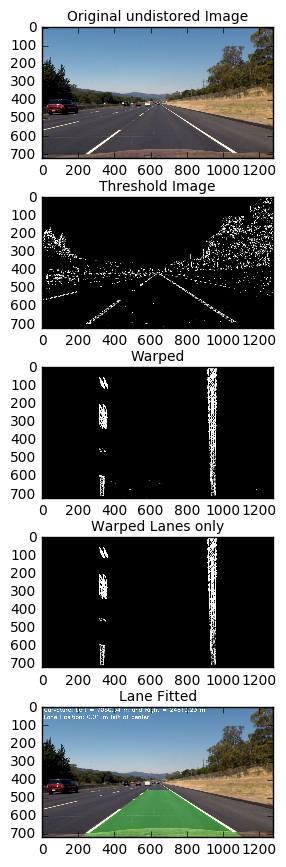

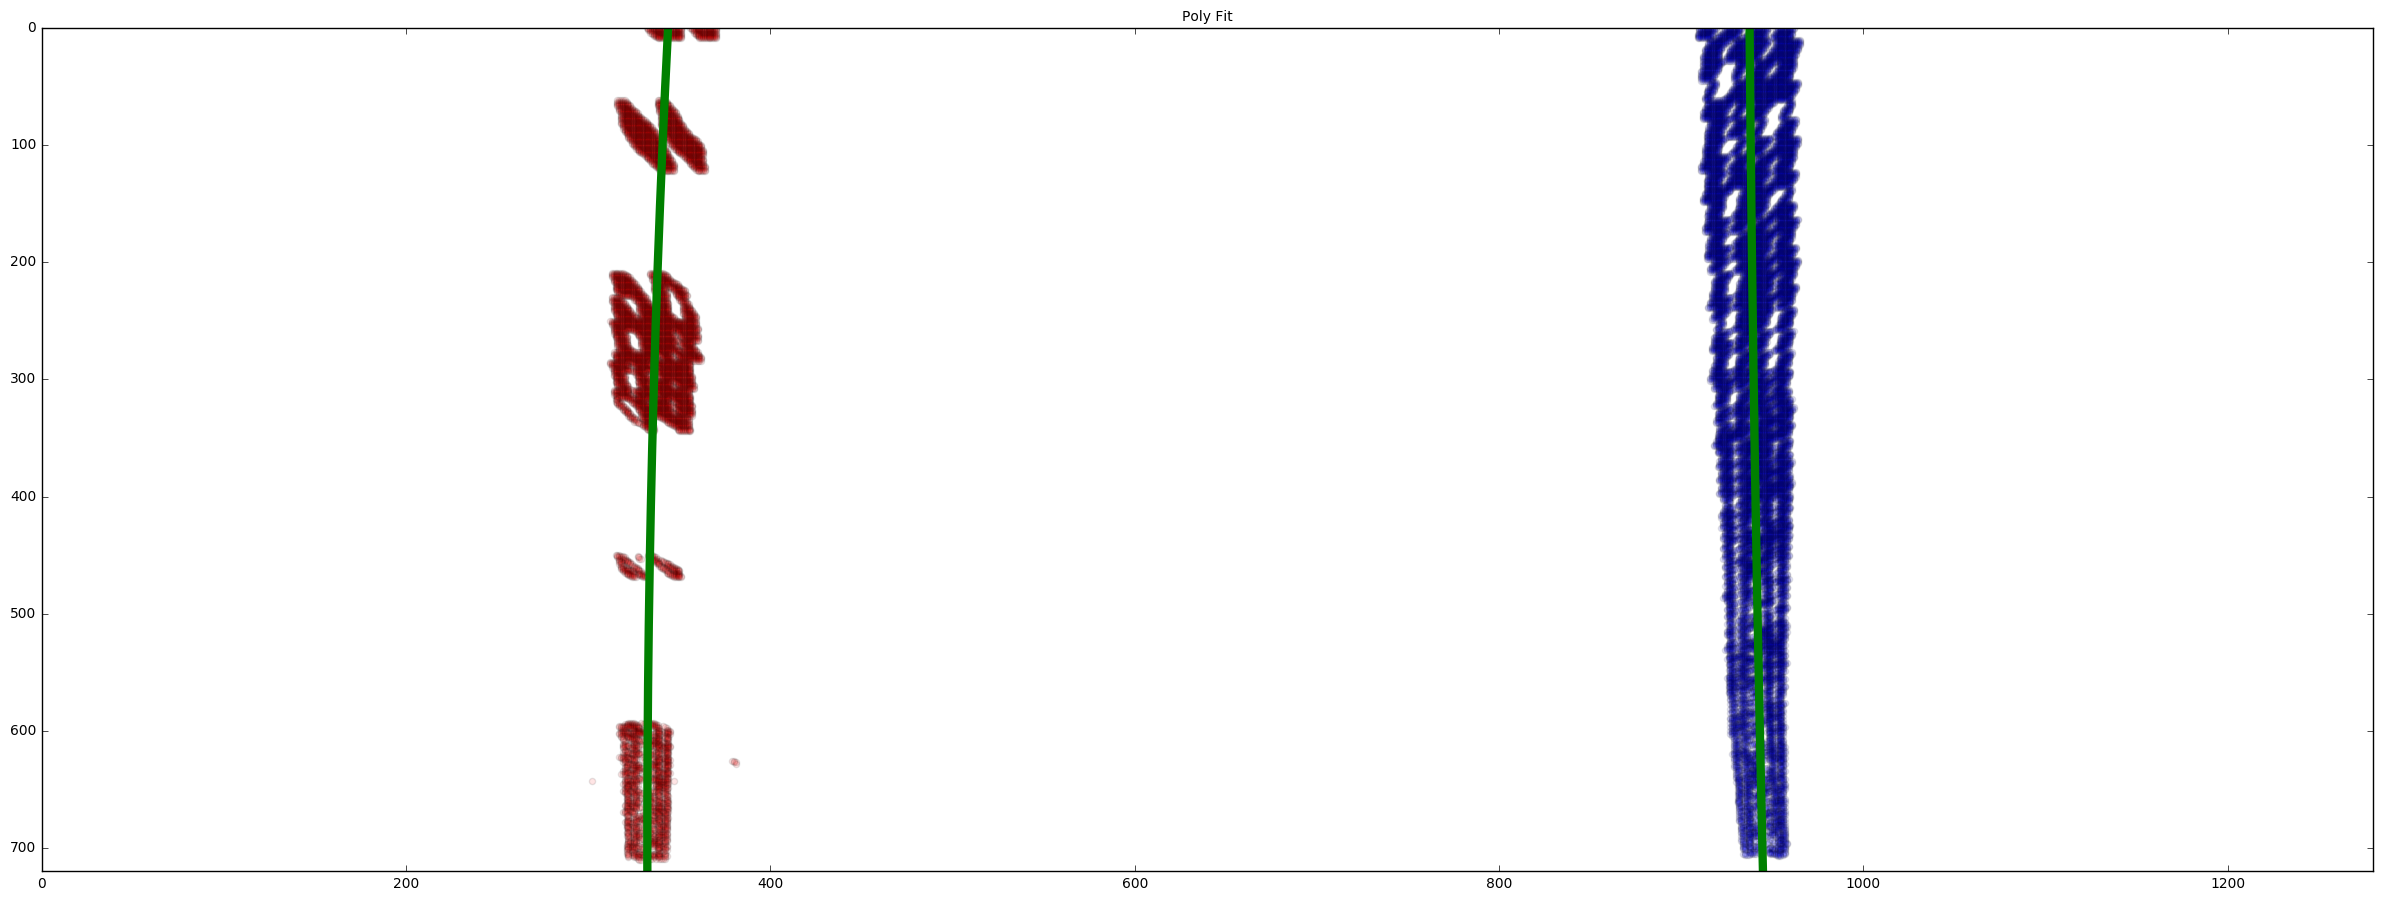

In [16]:
# Run pipeline on test images
%matplotlib inline

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# read in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]


# Make a list of test images
images = glob.glob('test_images/*.jpg')

left_line = Line()
right_line = Line()
bad_frames_cnt = 0

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    if fname[12:] == 'straight_lines2.jpg':
        plot_result=True
    else:
        plot_result=False
    fitted_img = pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=plot_result, video_clip=False)
    mpimg.imsave('output_images/final_output_'+fname[12:],fitted_img)





### Now Try on Video with tracker of recent measurements and recovery capabilities

We now run the above pipeline `(undistort->threshold->perspectiveXform->isolate_lines->fit_lines->color_Lane->reverse perspective->merge curvature and position data)` along with tracking capability on the video.

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
# two instances of Line to remember past history of line detection
# two global variable to hold past detection as I do not know how to pass additional paramters 
# in the function fl_image which can in turn be passed to process_image
left_line = Line()
right_line = Line()
bad_frames_cnt = 0

%matplotlib inline

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# read in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]


def process_image(img):
    return pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=True)

In [19]:

video1_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(video1_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:52<00:00,  7.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 53s


In [29]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))

### Analysis of above Video
The video under full pipeline runs well on the simple Project Video. It took me mnay iterations to get here. Some of the challenges I faced and areas of improvement are listed below:

**a) Finding a good image for perspetive transform:** Original test images supplied with the project did not have good exmample of straight lines. So I used `cv2.get_frame` to locate a good image and stored it as `test7.jpg`. I used undistored version of this image for the perspective matrix calculation. Later udacity provided two good examples of straight lane image. I then switched to `straight_lines2.jpg` for calibration.

**b) Locating the coordinate of trapizoid:** Even with a good image, it was not easy to locate accurtely the coordinates of 4 points on undistorted image and the corresponding coordinates in the bird's-eye view (top_down view). This turned out to be the area where I spent considerable time.

**c) Sliding window implementation:**It took me a while to get the algorithm going for sliding window. Working with (x,y) coordinates wherein numpy's first axis is y and 2nd axis is x created considerable confusion to map the physical image coordinates back and forth to the way numpy array of image is stored. The sliding window needs more improvement esp when the lanes curve a lot. Histogram technique to locate the start can fail in case of lanes that curve a lot in the perspetive image. This needs to be improved a lot esp. by combining the past detection from prior frames.

**d) Lane tracking:** This is still work in progress. I am not at all satisfied with the way I am storing and using this data for making corrections to lane estimates. My approach is still very crude and needs to be refined a lot to make it work esp on road when lanes curve a lot. The shortfall is demonstarted by the poor quality of result on challeneg videos.

**e) Thresholding:** Thresholding can be improved further to isolate lanes from rest of the image. I did not spend a whole lot of time trying more than basic techniques.


In [21]:

video2_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
output_clip2 = clip2.fl_image(process_image)
%time output_clip2.write_videofile(video2_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 6s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video2_output))

### Analysis of above result
As we can see, the pipeline fails esp on the left side. That is due to an dark colored break in road just inside left lane. This edge is mixed with the left lane edge and forces the poly_fit to find optimial fit considering both the edge points - i.e. left lane points and broken road.

In [ ]:

video3_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip('harder_challenge_video.mp4')
output_clip3 = clip3.fl_image(process_image)
%time output_clip3.write_videofile(video3_output, audio=False)

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video3_output))

### Analysis of Output above

Current pipeline completely fails on the harder challenge video. It shows the weakness of my pipeline as predicted above that it will fail on roads where lanes curve a lot or where there are other edges all over the road making isolation of lane pixels from others very tough.

Something to look into in future in my spare time.